# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 8: *KrawtchoukMoments*
Compute Krawtchouk moments for a region in an image. 
Compute moments, moments by using geometric moments and invariant moments 
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Set module functions
from ImageUtilities import imageReadL, plotImageL,createImageF, scaleImageL
from ImageRegionsUtilities import pixlesList, weightedKrawtchoukPolynomials,      \
                                       geometricMoments
from PrintUtilities import printImageRangeF
from PlotUtilities import plotSurface, plotCurve 

# Math and iteration
from math import  pi, atan, sin, cos, sqrt
from timeit import itertools

### Parameters:
    pathToDir = Input image directory
    imageName = Input image name
    p = Polynomial parameter. 0.5 for centralized polynomials. Power
    numMoments = Number of moments
    background = The gray level range of the background pixels

In [2]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter8/Input/")
imageName = "f14.png"
numMoments = 4
p = 0.5
background = [200, 255] # white background image
reducedSize = 80 # reduce the image size to avoid overflowing or use recurrence relations

###  Reduce the image size to avoid large exponents in the computation

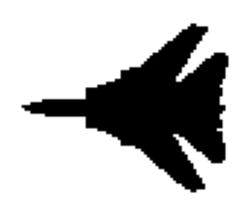

In [3]:
inputImage, inputWidth, inputHeight = imageReadL(pathToDir+imageName)

# Reduce the image size to avoid large exponents in the computation
scale = max(max(inputWidth, inputHeight) / float(reducedSize), 1.0)
width, height = int(inputWidth/scale), int(inputHeight/scale)
scaledImage = scaleImageL(inputImage, width, height)
plotImageL(scaledImage, figureSize = 3)


### Get a list that contains the pixels of the shape in the form (y,x,v) 

In [4]:
shapeImage = pixlesList(scaledImage, background)
numPoints = len(shapeImage)

### Polynomials, coefficients and weights for the Krawtchouk polynomials

In [5]:
# Considering that A*C = k. For a the coefficients and C the powers x, x^2, x^3,..  
N = max(width, height)
kW, aW, sigma, ro, w = weightedKrawtchoukPolynomials(p, N)

### Krawtchouk moments of the shape  by standard definition

In [6]:
Q = createImageF(numMoments, numMoments)
for m,n in itertools.product(range(0, numMoments), range(0, numMoments)):
    for indexPixel in range(0, numPoints):
        y, x = (shapeImage[indexPixel])[0], (shapeImage[indexPixel])[1]
        v = (shapeImage[indexPixel])[2]  
        Q[n,m] += w[x,m] * kW[x,m] * w[y,n] * kW[y,n] * v
printImageRangeF(Q, [0,numMoments-1],[0,numMoments-1], " 8.2f")



[    18.10    -3.98    10.77    -4.53 ]
[     6.86     3.83     3.68     2.52 ]
[     6.04    -3.63     6.14    -3.82 ]
[     6.07    -2.45    -0.17    -0.60 ]


### Krawtchouk moments from the geometric moments Gij = x**i , y**j.

In [7]:
G = createImageF(N, N)
for i,j in itertools.product(range(0, N), range(0, N)):
    for indexPixel in range(0, numPoints):
        y, x= (shapeImage[indexPixel])[0], (shapeImage[indexPixel])[1]
        v = (shapeImage[indexPixel])[2]   
        G[j,i] +=  sqrt(sigma[x] * sigma[y]) * y**j * x**i * v

Qs = createImageF(numMoments, numMoments) 
for m,n in itertools.product(range(0, numMoments), range(0, numMoments)):
    for i,j in itertools.product(range(0, N), range(0, N)):
        Qs[n,m] +=  aW[m,i] * aW[n,j] * G[j,i]

    Qs[n,m] *= (1.0 / sqrt(ro[n]*ro[m]))  
printImageRangeF(Qs, [0,numMoments-1],[0,numMoments-1], " 8.2f")



[    18.10    -3.98    10.77    -4.53 ]
[     6.86     3.83     3.68     2.52 ]
[     6.04    -3.63     6.14    -3.82 ]
[     6.07    -2.45    -0.17    -0.60 ]


### Invariant  Krawtchouk moments by using weighted invariant Geometric moments G(j,i)

In [8]:
Qi = createImageF(numMoments, numMoments)
M = geometricMoments(shapeImage, 3)

xc,yc = M[1,0]/M[0,0], M[0,1]/M[0,0]
m11 = M[1,1]/M[0,0] - xc*yc
m20 = M[2,0]/M[0,0] - xc**2
m02 = M[0,2]/M[0,0] - yc**2
    
if m20 < m02:  t = -(0.5 * atan(2.0*m11/(m20-m02)) + pi/2.0)
else:          t = -(0.5 * atan(2.0*m11/(m20-m02)))

# Scale
q, n2 = (N*N/2.0)/M[0,0],  N / 2.0

Nu = createImageF(N, N)
for j,i in itertools.product(range(0, N), range(0, N)):
    for indexPixel in range(0, numPoints):
        y, x = (shapeImage[indexPixel])[0], (shapeImage[indexPixel])[1], 
        val  = (shapeImage[indexPixel])[2]  
        
        # Invariant moments
        a =  ((x-xc)*sin(t) + (y-yc) * cos(t))
        b =  ((x-xc)*cos(t) - (y-yc) * sin(t))
        
        # To NxN image       
        u =  sqrt(q) * a + n2
        v =  sqrt(q) * b + n2
       
        if int(v) < N and int(u) < N:
            Nu[i,j] += a**i * b**j * val * sqrt(sigma[int(v)] * sigma[int(u)]) 
        
    c = 1.0 + ((i + j) / 2.0)    
    Nu[i,j] = (Nu[i,j] / pow(M[0,0],c)) 
    
for m,n in itertools.product(range(0, numMoments), range(0, numMoments)):
    # Descriptors
    for j,i in itertools.product(range(0, N), range(0, N)):
        Qi[n,m] +=  Nu[i,j] * aW[m,i] * aW[n,j]
        
    Qi[n,m] *= (1.0 / sqrt(ro[n]*ro[m]))  

printImageRangeF(Qi, [0,numMoments-1],[0,numMoments-1], " 8.2f")





[     0.01     0.06     0.38     1.95 ]
[     0.06     0.55     3.42    17.30 ]
[     0.38     3.42    21.33   108.06 ]
[     1.95    17.30   108.06   547.48 ]
